In [128]:
#install scikit-learn packages
pip install scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 21.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.9/29.9 MB 21.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
#imports
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
#imports
import pandas as pd 
import glob


#Group all weekly attendance data into one csv file
attendance_files = glob.glob('Attendance_Files/' + '*.csv')
df = pd.concat((pd.read_csv(file) for file in attendance_files), ignore_index=True)
df

df.to_csv('attendance.csv')



/var/folders/23/z3k66lxx0cd1jl6zg3b31qhr0000gn/T/ipykernel_99902/2735299125.py:8: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((pd.read_csv(file) for file in attendance_files), ignore_index=True)
/var/folders/23/z3k66lxx0cd1jl6zg3b31qhr0000gn/T/ipykernel_99902/2735299125.py:8: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((pd.read_csv(file) for file in attendance_files), ignore_index=True)
/var/folders/23/z3k66lxx0cd1jl6zg3b31qhr0000gn/T/ipykernel_99902/2735299125.py:8: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((pd.read_csv(file) for file in attendance_files), ignore_index=True)
/var/folders/23/z3k66lxx0cd1jl6zg3b31qhr0000gn/T/ipykernel_99902/2735299125.py:8: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.

In [5]:
#Read Ticket sales data
sales_df = pd.read_excel('Sales Report Data Cleaning.xlsx')



In [6]:
#Filter out ticket sales for only Singles and Non Complementary
sales_df = sales_df[sales_df['Name'] == 'Ticket Sales as of 9.15 Singles.xlsx']
sales_df = sales_df[~sales_df['ADJ.PGS'].isin(['C','N','W'])]



In [7]:
#Convert Event_Usage_date to datetime (utc = true needed for merge)
sales_df['EVENT_USAGE_DATE'] = pd.to_datetime(sales_df['EVENT_USAGE_DATE'], format='%Y-%m-%d', utc=True)
sales_df['EVENT_USAGE_DATE'] = sales_df['EVENT_USAGE_DATE'].dt.strftime('%Y-%m-%d')

#game_sales_df includes ticket count for sales per game
game_sales_df = sales_df.groupby('EVENT_USAGE_DATE').size().reset_index(name='Sales_Count')

#Filters ticket attendance for all tickets in filtered sales dataframe
attendance_df = pd.read_csv('attendance.csv')
attendance_df = attendance_df[attendance_df['TICKET_ID'].isin(sales_df['TICKET_ID'])]

#Groups ticket count for attendance per game
ticket_attendance_df = attendance_df.groupby('EVENT_DATE').size().reset_index(name='Attendance_Count')

game_sales_df.head(5)


/var/folders/23/z3k66lxx0cd1jl6zg3b31qhr0000gn/T/ipykernel_99902/1963499903.py:9: DtypeWarning: Columns (30,46) have mixed types. Specify dtype option on import or set low_memory=False.
  attendance_df = pd.read_csv('attendance.csv')


,EVENT_USAGE_DATE,Sales_Count
0,2024-04-02,2750
1,2024-04-03,118
2,2024-04-04,85
3,2024-04-05,590
4,2024-04-06,637


In [8]:
ticket_attendance_df.head(5)

#Convert Event_Date to datetime (utc = true needed for merge)
ticket_attendance_df['EVENT_DATE'] = pd.to_datetime(ticket_attendance_df['EVENT_DATE'], format='%d-%b-%Y %I:%M %p', utc=True)
ticket_attendance_df['EVENT_DATE'] = ticket_attendance_df['EVENT_DATE'].dt.strftime('%Y-%m-%d')

ticket_attendance_df



,EVENT_DATE,Attendance_Count
0,2024-08-01,1295
1,2024-05-01,210
2,2024-09-01,2448
3,2024-04-02,1956
4,2024-08-02,2342
...,...,...
68,2024-04-30,279
69,2024-08-30,2480
70,2024-07-30,1253
71,2024-08-31,2964


In [9]:
#merge attendance and sales dataframes
final_df = pd.merge(ticket_attendance_df, game_sales_df, how= 'inner', left_on='EVENT_DATE', right_on='EVENT_USAGE_DATE')
final_df


,EVENT_DATE,Attendance_Count,EVENT_USAGE_DATE,Sales_Count
0,2024-08-01,1295,2024-08-01,1519
1,2024-05-01,210,2024-05-01,264
2,2024-09-01,2448,2024-09-01,2804
3,2024-04-02,1956,2024-04-02,2750
4,2024-08-02,2342,2024-08-02,2823
...,...,...,...,...
68,2024-04-30,279,2024-04-30,322
69,2024-08-30,2480,2024-08-30,3000
70,2024-07-30,1253,2024-07-30,1481
71,2024-08-31,2964,2024-08-31,3632


In [10]:
#Calculate Attendance percentage from ticket sales
final_df['AttendancePercentage'] = final_df['Attendance_Count'] / final_df['Sales_Count'] * 100
final_df['AttendancePercentage'] = final_df['AttendancePercentage'].round(2)
final_df = final_df.sort_values(by='AttendancePercentage', ascending=False)

#Drop extra gamedate column
final_df = final_df.drop(columns=['EVENT_USAGE_DATE'])
final_df

,EVENT_DATE,Attendance_Count,Sales_Count,AttendancePercentage
63,2024-05-25,2933,3114,94.19
62,2024-05-24,1909,2038,93.67
11,2024-05-04,1961,2100,93.38
5,2024-05-02,782,839,93.21
64,2024-05-26,2752,2953,93.19
...,...,...,...,...
3,2024-04-02,1956,2750,71.13
18,2024-06-06,411,579,70.98
46,2024-04-18,448,646,69.35
58,2024-06-22,1418,2079,68.21


In [11]:
#Load in gameday Weather Data
weather_df = pd.read_csv('24GameWeather/Promotions+Weather24.csv')

#Convert GAME_DATE
weather_df['GAME_DATE'] = pd.to_datetime(weather_df['GAME_DATE'], format='%m/%d/%y', utc=True)
weather_df['GAME_DATE'] = weather_df['GAME_DATE'].dt.strftime('%Y-%m-%d')

#Drop Faulty data columns 
weather_df = weather_df.drop(columns=['Unnamed: 0', 'Unnamed: 13', 'Unnamed: 14'])
weather_df


,GAME_DATE,DAY,max_temp,min_temp,avgtemp,Rain,Snow,Condition,Weather,Temp,Temp_Diff,Promotions/Events
0,2024-04-02,Tue,41.9,36.5,39.9,100,0,Light rain,CLOUDY,52,12,0
1,2024-04-03,Wed,37.1,32.2,34.8,0,100,Heavy snow,RAIN,37,2,Opening Day / Opening Day Photo Giveaway / Fre...
2,2024-04-04,Thu,32.5,31.4,31.9,0,100,Heavy snow,SNOW,34,2,0
3,2024-04-05,Fri,37.5,28.3,33.0,0,100,Moderate or heavy snow showers,CLOUDY,41,8,0
4,2024-04-06,Sat,39.6,33.4,36.2,0,100,Moderate or heavy snow showers,OVERCAST,42,6,WooSox Tumbler Giveaway / Fireworks / Clinton ...
...,...,...,...,...,...,...,...,...,...,...,...,...
70,2024-09-11,Wed,74.1,50.8,61.4,0,0,Sunny,CLEAR,74,13,Fan Appreciation Week / Taco & Tequila Tuesday...
71,2024-09-12,Thu,76.9,53.7,63.8,0,0,Partly cloudy,CLEAR,76,12,Fan Appreciation Week / Batting Practice / Pre...
72,2024-09-13,Fri,80.9,56.0,67.6,100,0,Sunny,CLEAR,81,13,Fan Appreciation Week / Batting Practice / Thr...
73,2024-09-14,Sat,80.3,60.6,68.8,0,0,Partly cloudy,SUNNY,80,11,Fan Appreciation Week / Batting Practice / Pre...


In [12]:
final_weather_df = pd.merge(final_df, weather_df, how='inner', left_on='EVENT_DATE', right_on='GAME_DATE')
final_weather_df = final_weather_df.drop(columns=['GAME_DATE'])
final_weather_df.sort_values(by='EVENT_DATE', ascending=True, inplace=True)
final_weather_df

,EVENT_DATE,Attendance_Count,Sales_Count,AttendancePercentage,DAY,max_temp,min_temp,avgtemp,Rain,Snow,Condition,Weather,Temp,Temp_Diff,Promotions/Events
68,2024-04-02,1956,2750,71.13,Tue,41.9,36.5,39.9,100,0,Light rain,CLOUDY,52,12,0
50,2024-04-05,485,590,82.20,Fri,37.5,28.3,33.0,0,100,Moderate or heavy snow showers,CLOUDY,41,8,0
59,2024-04-06,510,637,80.06,Sat,39.6,33.4,36.2,0,100,Moderate or heavy snow showers,OVERCAST,42,6,WooSox Tumbler Giveaway / Fireworks / Clinton ...
12,2024-04-07,560,621,90.18,Sun,41.4,33.2,36.8,0,100,Light snow showers,CLOUDY,42,5,Meet the Team Party / Sports Memorabilia Day /...
7,2024-04-16,1079,1160,93.02,Tue,58.4,41.4,49.0,0,0,Partly cloudy,PARTLY CLOUDY,64,15,Sunday Funday / Kids Run the Bases / Bark in t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,2024-09-11,627,729,86.01,Wed,74.1,50.8,61.4,0,0,Sunny,CLEAR,74,13,Fan Appreciation Week / Taco & Tequila Tuesday...
64,2024-09-12,767,979,78.35,Thu,76.9,53.7,63.8,0,0,Partly cloudy,CLEAR,76,12,Fan Appreciation Week / Batting Practice / Pre...
66,2024-09-13,2111,2729,77.35,Fri,80.9,56.0,67.6,100,0,Sunny,CLEAR,81,13,Fan Appreciation Week / Batting Practice / Thr...
61,2024-09-14,2492,3126,79.72,Sat,80.3,60.6,68.8,0,0,Partly cloudy,SUNNY,80,11,Fan Appreciation Week / Batting Practice / Pre...


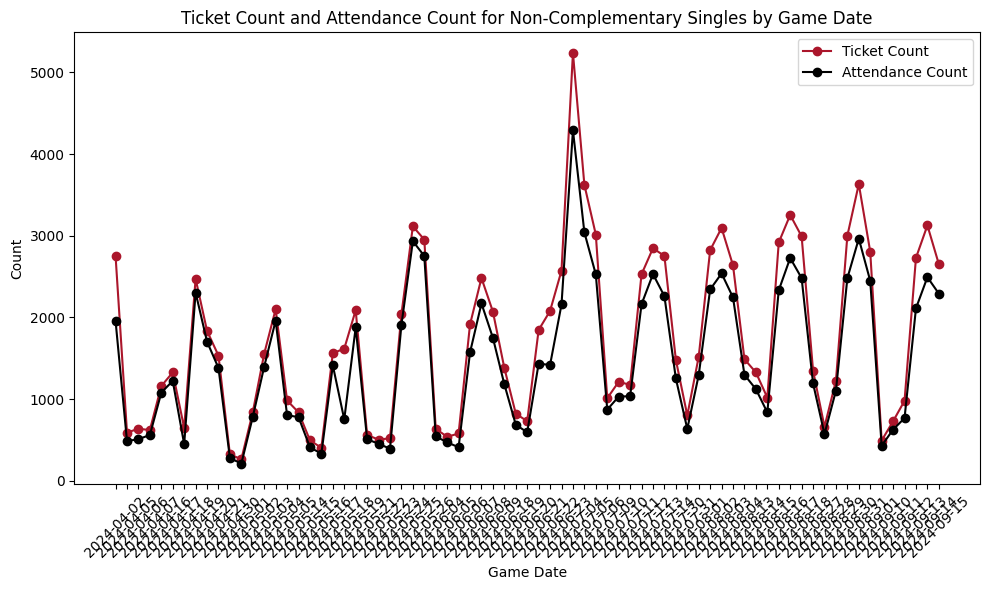

In [13]:
import matplotlib.pyplot as plt

#Plot Attendance and Sales tickets together
plt.figure(figsize=(10, 6))
plt.plot(final_weather_df['EVENT_DATE'], final_weather_df['Sales_Count'], color='#ab162b', label='Ticket Count', marker='o')
plt.plot(final_weather_df['EVENT_DATE'], final_weather_df['Attendance_Count'], color='#000000', label='Attendance Count', marker='o')

# Adding labels and title
plt.xlabel('Game Date')
plt.ylabel('Count')
plt.title('Ticket Count and Attendance Count for Non-Complementary Singles by Game Date')
plt.legend()

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

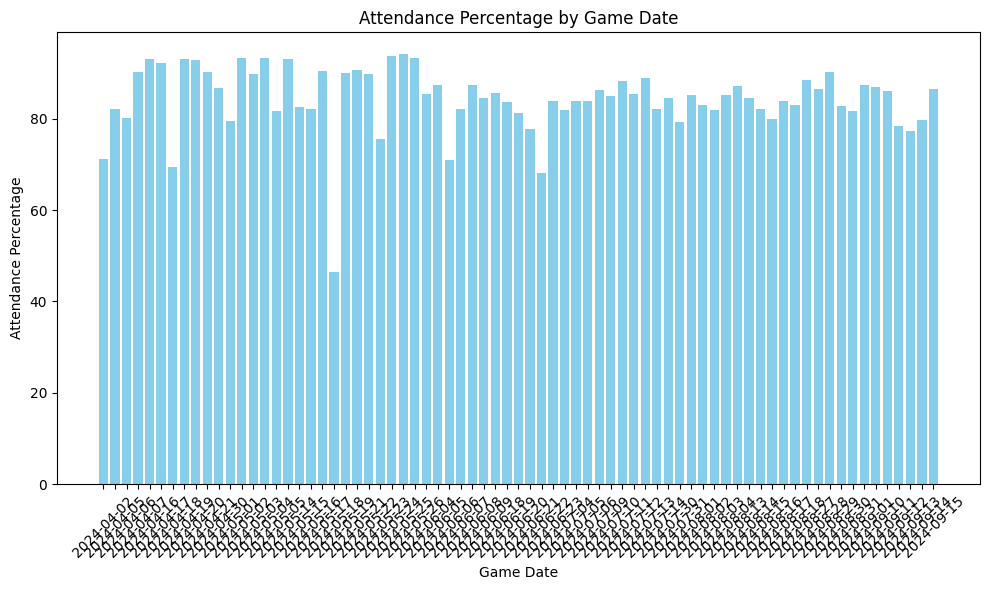

In [13]:
#Plot attendance percentage per game
plt.figure(figsize=(10, 6))
plt.bar(final_weather_df['EVENT_DATE'], final_weather_df['AttendancePercentage'], color='skyblue')

# Adding labels and title
plt.xlabel('Game Date')
plt.ylabel('Attendance Percentage')
plt.title('Attendance Percentage by Game Date')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
#Get all weather condition values
condition_values = final_weather_df['Condition'].unique()
print(condition_values)

['Light rain' 'Moderate or heavy snow showers' 'Light snow showers'
 'Partly cloudy' 'Overcast' 'Light drizzle' 'Patchy rain possible' 'Fog'
 'Light rain shower' 'Mist' 'Patchy light rain' 'Sunny' 'Moderate rain'
 'Moderate or heavy rain shower' 'Moderate rain at times']


In [32]:
#Function that changes weather conditions into 'Rain', 'Snow', 'Cloudy', 'Fog', 'Sunny'
def categorize_condition(condition):
    if 'rain' in str(condition).lower() or 'drizzle' in str(condition).lower():
        return 'Rain'
    elif 'snow' in str(condition).lower():
        return 'Snow'
    elif condition in ['Partly cloudy', 'Overcast']:
        return 'Cloudy'
    elif condition in ['Mist', 'Fog']:
        return 'Fog'
    else:
        return 'Sunny'


#apply function to condition column
final_weather_df['Condition'] = final_weather_df['Condition'].apply(categorize_condition)
final_weather_df.to_csv('Singles_Game_Attendance.csv')



In [33]:
final_weather_df

,EVENT_DATE,Attendance_Count,Sales_Count,AttendancePercentage,DAY,max_temp,min_temp,avgtemp,Rain,Snow,Condition,Weather,Temp,Temp_Diff,Promotions/Events
68,2024-04-02,1956,2750,71.13,Tue,41.9,36.5,39.9,100,0,Rain,CLOUDY,52,12,0
50,2024-04-05,485,590,82.20,Fri,37.5,28.3,33.0,0,100,Snow,CLOUDY,41,8,0
59,2024-04-06,510,637,80.06,Sat,39.6,33.4,36.2,0,100,Snow,OVERCAST,42,6,WooSox Tumbler Giveaway / Fireworks / Clinton ...
12,2024-04-07,560,621,90.18,Sun,41.4,33.2,36.8,0,100,Snow,CLOUDY,42,5,Meet the Team Party / Sports Memorabilia Day /...
7,2024-04-16,1079,1160,93.02,Tue,58.4,41.4,49.0,0,0,Cloudy,PARTLY CLOUDY,64,15,Sunday Funday / Kids Run the Bases / Bark in t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,2024-09-11,627,729,86.01,Wed,74.1,50.8,61.4,0,0,Sunny,CLEAR,74,13,Fan Appreciation Week / Taco & Tequila Tuesday...
64,2024-09-12,767,979,78.35,Thu,76.9,53.7,63.8,0,0,Cloudy,CLEAR,76,12,Fan Appreciation Week / Batting Practice / Pre...
66,2024-09-13,2111,2729,77.35,Fri,80.9,56.0,67.6,100,0,Sunny,CLEAR,81,13,Fan Appreciation Week / Batting Practice / Thr...
61,2024-09-14,2492,3126,79.72,Sat,80.3,60.6,68.8,0,0,Cloudy,SUNNY,80,11,Fan Appreciation Week / Batting Practice / Pre...


In [45]:
test1_df = final_weather_df.groupby(by='Condition').size().reset_index(name='Condition_Count')
test1_df

,Condition,Condition_Count
0,Cloudy,13
1,Fog,14
2,Rain,38
3,Snow,3
4,Sunny,5


In [34]:
#Convert Condition column into a dummy variable 
test_df = pd.get_dummies(final_weather_df, columns=['Condition'], dtype=float)
test_df


,EVENT_DATE,Attendance_Count,Sales_Count,AttendancePercentage,DAY,max_temp,min_temp,avgtemp,Rain,Snow,Weather,Temp,Temp_Diff,Promotions/Events,Condition_Cloudy,Condition_Fog,Condition_Rain,Condition_Snow,Condition_Sunny
68,2024-04-02,1956,2750,71.13,Tue,41.9,36.5,39.9,100,0,CLOUDY,52,12,0,0.0,0.0,1.0,0.0,0.0
50,2024-04-05,485,590,82.20,Fri,37.5,28.3,33.0,0,100,CLOUDY,41,8,0,0.0,0.0,0.0,1.0,0.0
59,2024-04-06,510,637,80.06,Sat,39.6,33.4,36.2,0,100,OVERCAST,42,6,WooSox Tumbler Giveaway / Fireworks / Clinton ...,0.0,0.0,0.0,1.0,0.0
12,2024-04-07,560,621,90.18,Sun,41.4,33.2,36.8,0,100,CLOUDY,42,5,Meet the Team Party / Sports Memorabilia Day /...,0.0,0.0,0.0,1.0,0.0
7,2024-04-16,1079,1160,93.02,Tue,58.4,41.4,49.0,0,0,PARTLY CLOUDY,64,15,Sunday Funday / Kids Run the Bases / Bark in t...,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,2024-09-11,627,729,86.01,Wed,74.1,50.8,61.4,0,0,CLEAR,74,13,Fan Appreciation Week / Taco & Tequila Tuesday...,0.0,0.0,0.0,0.0,1.0
64,2024-09-12,767,979,78.35,Thu,76.9,53.7,63.8,0,0,CLEAR,76,12,Fan Appreciation Week / Batting Practice / Pre...,1.0,0.0,0.0,0.0,0.0
66,2024-09-13,2111,2729,77.35,Fri,80.9,56.0,67.6,100,0,CLEAR,81,13,Fan Appreciation Week / Batting Practice / Thr...,0.0,0.0,0.0,0.0,1.0
61,2024-09-14,2492,3126,79.72,Sat,80.3,60.6,68.8,0,0,SUNNY,80,11,Fan Appreciation Week / Batting Practice / Pre...,1.0,0.0,0.0,0.0,0.0


In [36]:
# Define features (X) and target variable (y)
X = test_df[['Sales_Count','max_temp', 'Condition_Cloudy', 'Condition_Fog', 'Condition_Sunny', 'Condition_Rain', 'Condition_Snow']]
y = test_df['Attendance_Count']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

params = np.append(model.intercept_,model.coef_)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Coefficients of the model
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
#newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))

# Note if you don't want to use a DataFrame replace the two lines above with
newX = np.append(np.ones((len(X),1)), X, axis=1)
# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = mse*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params / sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]
sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
myDF3.index = X2.columns.values
print(myDF3)


Mean Squared Error: 24511.448567799016
R-squared: 0.949250438581934
Coefficients: [  0.84647558  -1.61996655 -84.61343402  30.42509196  70.25582842
  22.90318169 -38.97066804]
Intercept: 99.86372327844765


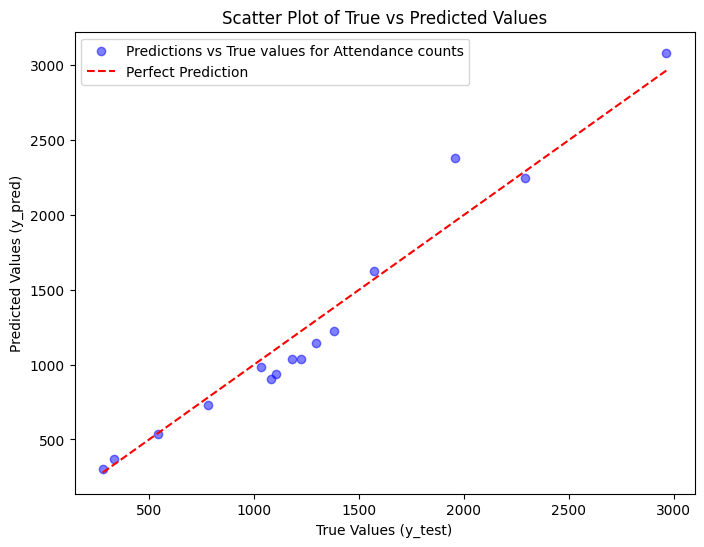

In [46]:
#Plot prediction values vs true values for attendance counts
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Predictions vs True values for Attendance counts')

# Adding a line representing the perfect prediction (y = x)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')

# Labels and title
plt.xlabel('True Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Scatter Plot of True vs Predicted Values')
plt.legend()
plt.show()